## While we start, please run the cell below. It will set up the environment for you

In [1]:
# Download data for he project
!wget -r -O diabetes_data.csv https://raw.githubusercontent.com/mandar-karhade/Medcon2024/main/Data%20files/diabetes_data.csv

# Install all the libraries as a one single statement
!pip -q install  pandas>=2.2.2 numpy scikit-learn seaborn joblib matplotlib>=3.8.0 mlflow==2.16.2 shap pycaret tabulate
# seaborn matplotlib ydata-profiling[notebook] missingno pycaret[analysis] PyYAML
# !pip -qq install joblib mlflow shap  interpret-community Werkzeug


will be placed in the single file you specified.

--2024-11-10 21:10:32--  https://raw.githubusercontent.com/mandar-karhade/Medcon2024/main/Data%20files/diabetes_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23875 (23K) [text/plain]
Saving to: ‘diabetes_data.csv’

diabetes_data.csv   100%[===================>]  23.32K  --.-KB/s    in 0.002s  

2024-11-10 21:10:32 (13.2 MB/s) - ‘diabetes_data.csv’ saved [23875/23875]

FINISHED --2024-11-10 21:10:32--
Total wall clock time: 0.3s
Downloaded: 1 files, 23K in 0.002s (13.2 MB/s)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you ha

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import numpy as np
import shap

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

In [56]:



def print_nice_table(df, max_rows=None, max_cols=None):
    """
    Print a pandas DataFrame in a nice tabular format.

    :param df: pandas DataFrame to print
    :param max_rows: maximum number of rows to display (None for all)
    :param max_cols: maximum number of columns to display (None for all)
    """
    # Set pandas options
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.expand_frame_repr', False)

    # Slice the DataFrame if max_rows or max_cols is specified
    if max_rows is not None:
        df = df.head(max_rows)
    if max_cols is not None:
        df = df.iloc[:, :max_cols]

    # Convert DataFrame to tabulate format
    table = tabulate(df, headers='keys', tablefmt='pretty', showindex=True)

    # Print the table
    print(table)

    # Reset pandas options
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.expand_frame_repr')

def print_confusion_matrix(cm):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return plt

def print_feature_importance(X, importances_, model=None):
    """Print feature importance using both traditional and SHAP methods

    Args:
        X: Feature dataset
        importances_: Feature importance scores from model
        model: Optional trained model for SHAP values
    """
    # Traditional feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.round(importances_, decimals=4)
    }).sort_values('importance', ascending=False)

    print("\nTraditional Feature Importance:")
    print_nice_table(feature_importance)

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='importance', y='feature', data=feature_importance)

    for i, v in enumerate(feature_importance['importance']):
        ax.text(v, i, f' {v:.4f}', va='center')

    plt.title('Traditional Feature Importance')
    plt.tight_layout()
    plt.close()
    return plt



def plot_hyperparameter_effect_curves(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    the np.linspace argument is training data using 10% to 100% at each iteration to show the effect of one of the parameters (training sample size)
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    axes[0].set_ylim(0,1)


    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt



def plot_waterfall_shap(model, X, observation):
    """
    Create SHAP visualizations for the model
    """
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    print(shap.plots.waterfall(shap_values[observation], max_display=14))

def plot_beeswarm_shap(model, X):
    """
    Create SHAP visualizations for the model
    """
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    print(shap.plots.beeswarm(shap_values, max_display=14))


def plot_learning_curve_hyperparameters(
    X,                          # Feature dataset
    y,                          # Target variable
    hyperparameter,             # Name of hyperparameter to test
    param_range,                # Range of values to test for the hyperparameter
    n_estimators=100,           # Number of trees in the forest
    test_size=0.2,              # 20% of data used for testing
    random_state=42             # Seed for reproducibility
    ):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    train_scores = []
    test_scores = []

    for param_value in param_range:
        rf_params = {
            'n_estimators': n_estimators,
            'random_state': random_state,
            hyperparameter: param_value
        }
        rf = RandomForestClassifier(**rf_params)
        rf.fit(X_train, y_train)

        train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
        test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_scores, label='Training score')
    plt.plot(param_range, test_scores, label='Test score')
    plt.xlabel(f'{hyperparameter} value')
    plt.ylabel('Accuracy Score')
    plt.title(f'Learning Curve: Accuracy vs {hyperparameter}')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

---

## Base model example: Random Forest


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Sample data:
+----+-------------+---------+---------------+---------------+---------+------+--------------------------+------+---------+
|    | Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI  | DiabetesPedigreeF

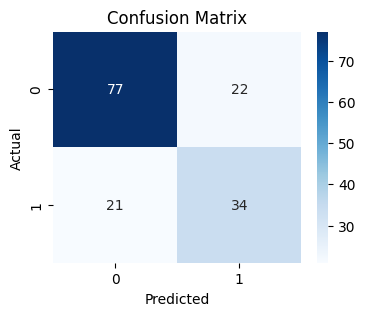


Traditional Feature Importance:
+---+--------------------------+------------+
|   |         feature          | importance |
+---+--------------------------+------------+
| 1 |         Glucose          |   0.2589   |
| 5 |           BMI            |    0.17    |
| 7 |           Age            |   0.1409   |
| 6 | DiabetesPedigreeFunction |   0.1238   |
| 2 |      BloodPressure       |   0.0881   |
| 0 |       Pregnancies        |   0.0766   |
| 4 |         Insulin          |   0.0761   |
| 3 |      SkinThickness       |   0.0656   |
+---+--------------------------+------------+

Model saved as 'diabetes_prediction_model_rf_classifier.joblib'

Experiment completed successfully!


In [58]:
# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('diabetes_data.csv')

# Display basic information about the dataset
print(data.info())
print("\nSample data:")
print_nice_table(data, max_rows=20)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
report = classification_report(y_test, y_pred, output_dict = True)
df_report = pd.DataFrame(report)
df_report = df_report.round(3)
print_nice_table(df_report)
print("\n" + "-"*100)


# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)
plt = print_confusion_matrix(cm)
plt.show()
plt.close()


# Feature importance
plt = print_feature_importance(X, rf_classifier.feature_importances_)
plt.show()
plt.close()


# Save the model
import joblib
joblib.dump(rf_classifier, 'diabetes_prediction_model_rf_classifier.joblib')
print("\nModel saved as 'diabetes_prediction_model_rf_classifier.joblib'")

print("\nExperiment completed successfully!")

## Local vs Global feature importance

### Local Feature Importance:
- Explains predictions for individual instances
- Shows how each feature contributed to moving the prediction from baseline (average model output) to the final prediction
- Helps understand why a specific prediction was made
- Useful for:
  * Explaining decisions to stakeholders
  * Debugging model behavior on specific cases
  * Ensuring fairness for individual predictions

### Global Feature Importance:
- Aggregates SHAP values across all instances
- Shows overall impact of features on model predictions
- Usually calculated by taking mean absolute SHAP values
- Helps understand model behavior at dataset level
- Useful for:
  * Feature selection
  * Model interpretation
  * Understanding general patterns


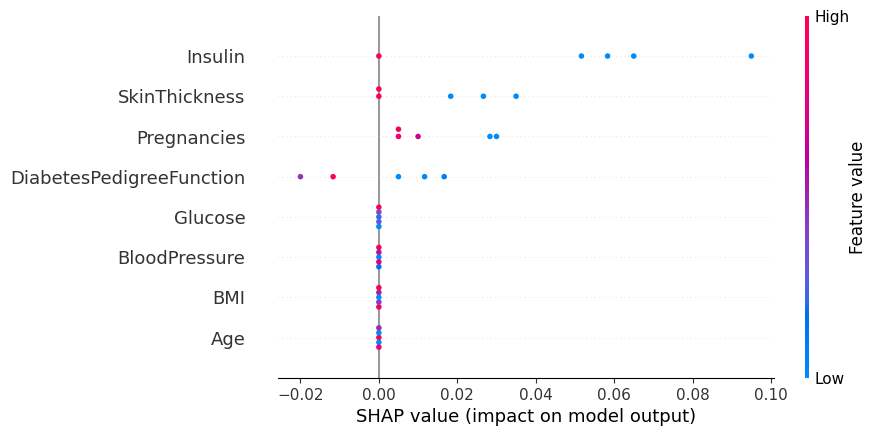

---------------------------------------------------------------------------------------------------- 
feature importance for observation 0


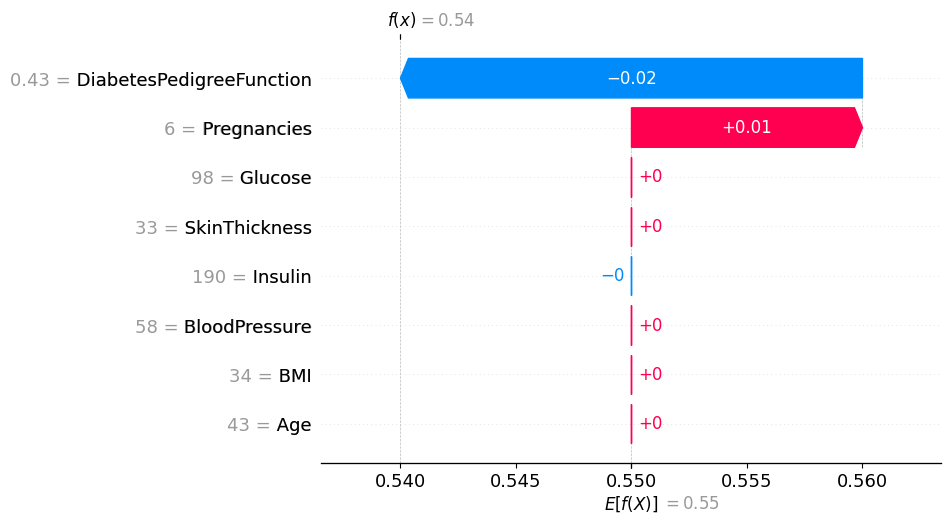

---------------------------------------------------------------------------------------------------- 
feature importance for observation 1


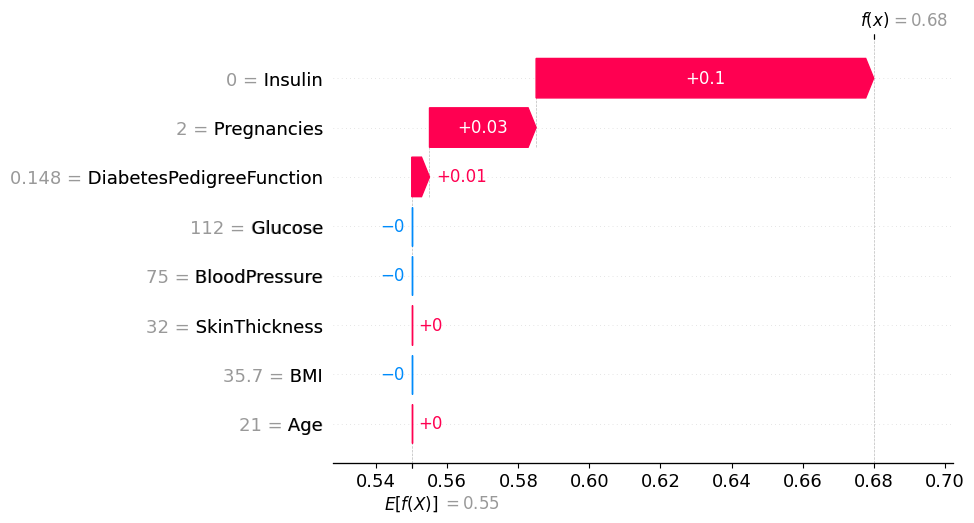

---------------------------------------------------------------------------------------------------- 
feature importance for observation 2


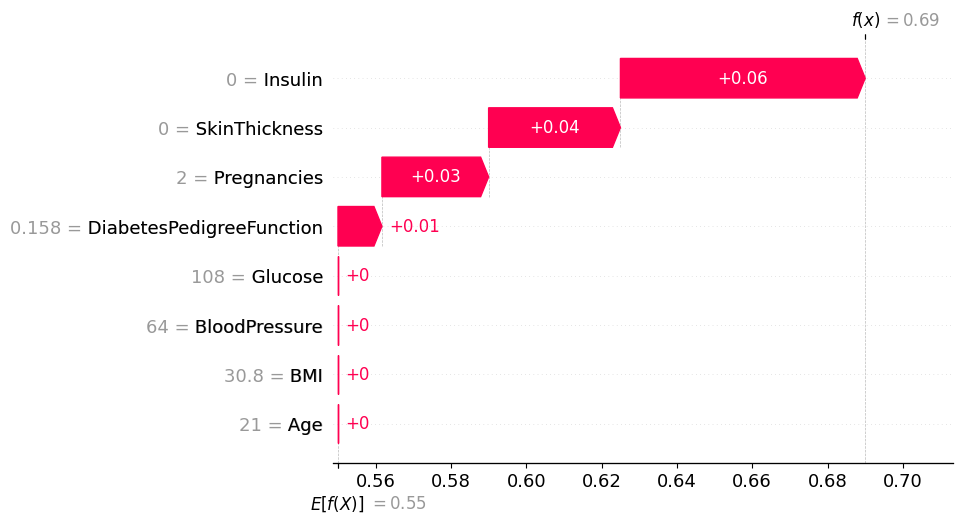

---------------------------------------------------------------------------------------------------- 
feature importance for observation 3


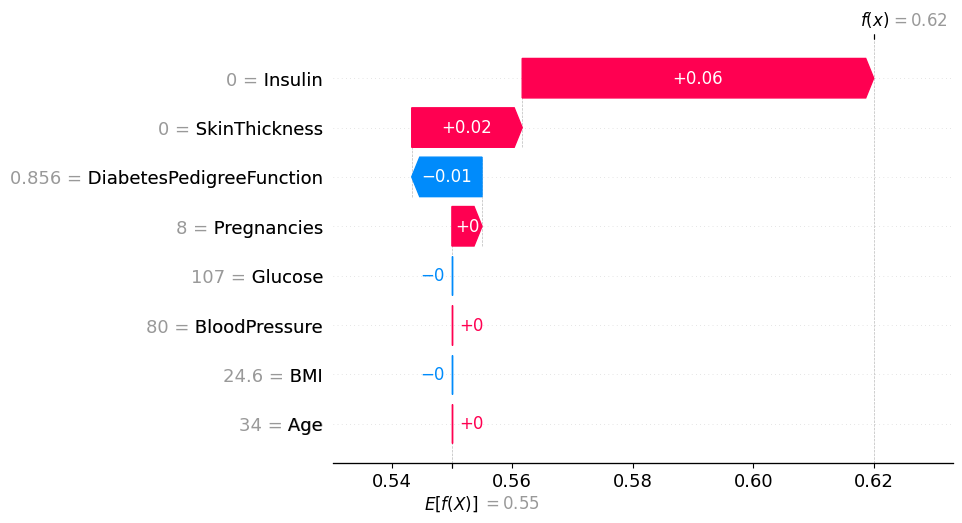

---------------------------------------------------------------------------------------------------- 
feature importance for observation 4


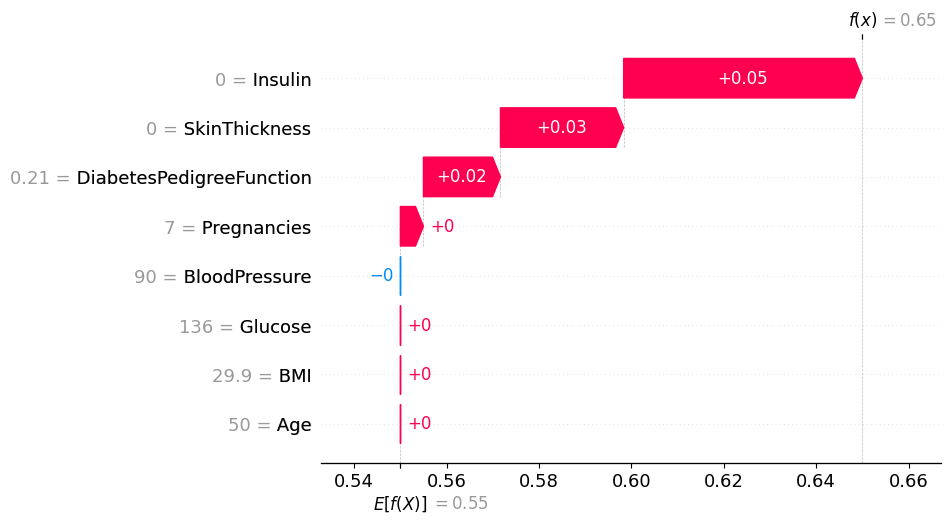

In [66]:
# returns predicted probabilities based on the input data values
def rf_classofier_predictions_f(x):
    return rf_classifier.predict_proba(x)[:, 1]

# Calculates median values for each feature in training data
# Reshapes into a single row with same number of columns as X_train
# Acts as a background reference dataset for SHAP calculations
med = X_train.median().values.reshape((1, X_train.shape[1]))

# SHAP processing for explainer over first 1000 rows of data
explainer = shap.Explainer(rf_classofier_predictions_f, med)
shap_values = explainer(X_test.iloc[0:1000, :])

# Plot global representation of the local importances
shap.plots.beeswarm(shap_values[0:5])


for i in range(5):
  # i = random.randint(0,5)
  print(f"{'-'*100} \nfeature importance for observation {i}")
  shap.plots.waterfall(shap_values[i])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Sample data:
+----+-------------+---------+---------------+---------------+---------+------+--------------------------+------+---------+
|    | Pregnancies | Glucose | BloodPressure | SkinThickness | Insulin | BMI  | DiabetesPedigreeF

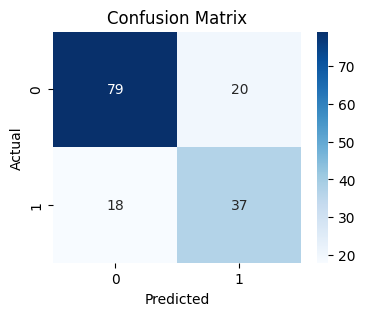


Feature Importance (Logistic Regression Coefficients):
+---+--------------------------+------------+
|   |         feature          | importance |
+---+--------------------------+------------+
| 1 |         Glucose          |   1.0713   |
| 5 |           BMI            |   0.7782   |
| 7 |           Age            |   0.4212   |
| 6 | DiabetesPedigreeFunction |   0.2306   |
| 0 |       Pregnancies        |   0.2126   |
| 3 |      SkinThickness       |   0.0457   |
| 4 |         Insulin          |  -0.2008   |
| 2 |      BloodPressure       |  -0.2478   |
+---+--------------------------+------------+


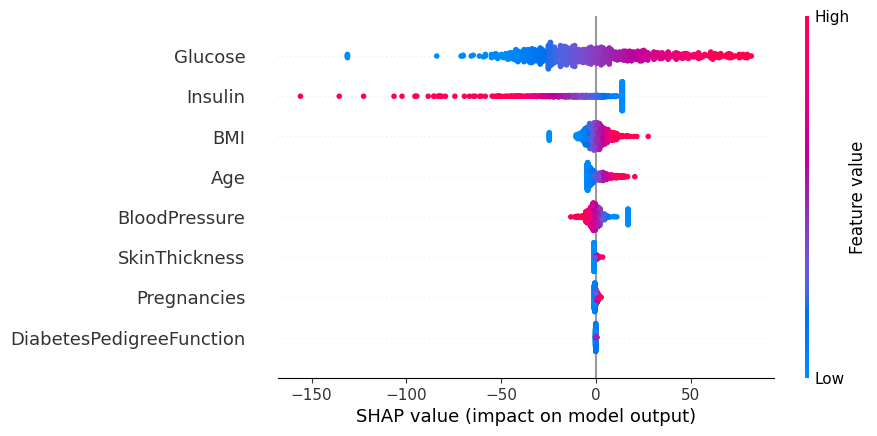

None
---------------------------------------------------------------------------------------------------- 
feature importance for observation 20


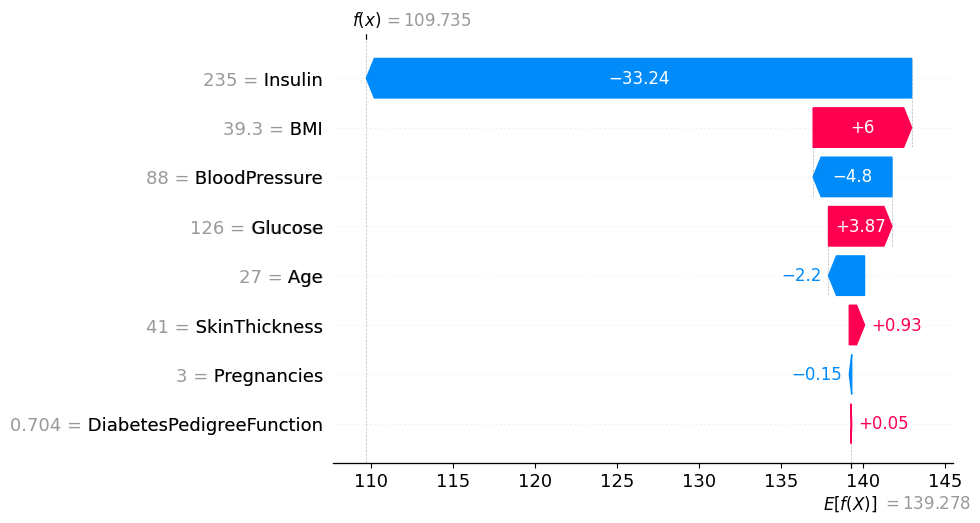

None
---------------------------------------------------------------------------------------------------- 
feature importance for observation 22


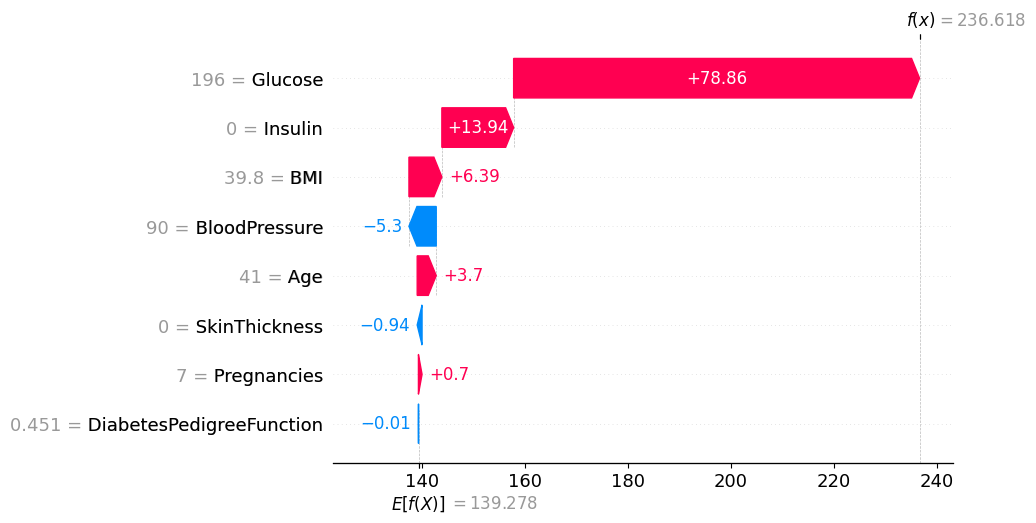

None
---------------------------------------------------------------------------------------------------- 
feature importance for observation 24


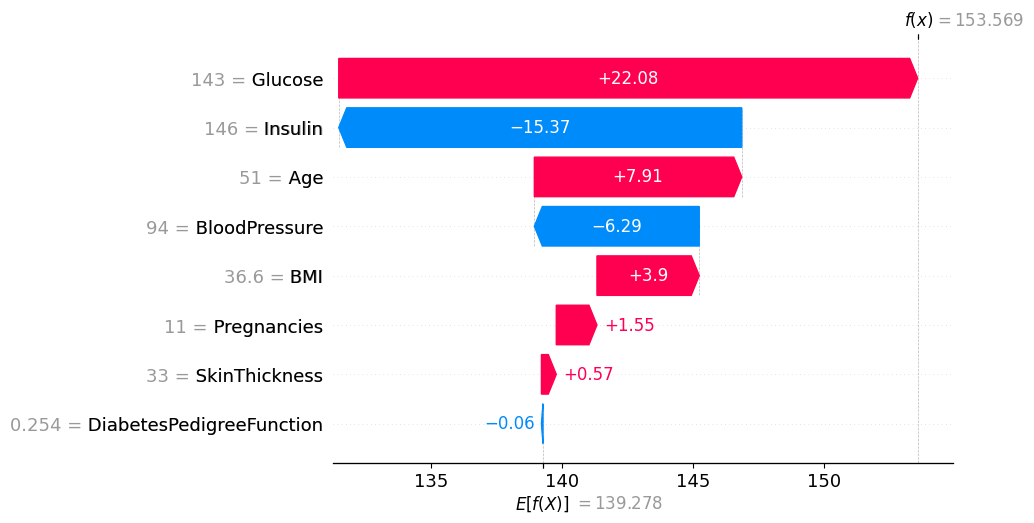

None
---------------------------------------------------------------------------------------------------- 
feature importance for observation 26


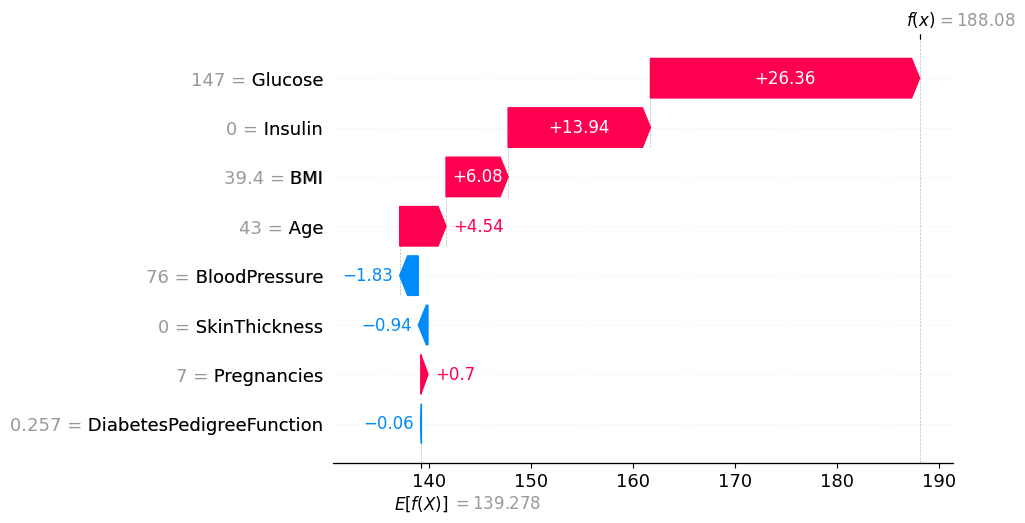

None

Model saved as 'diabetes_prediction_model_linear_classifier.joblib'

Experiment completed successfully!


In [28]:
# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('diabetes_data.csv')

# Display basic information about the dataset
print(data.info())
print("\nSample data:")
print_nice_table(data, max_rows=20)

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model (instead of Linear Regression)
linear_classifier = LogisticRegression()
linear_classifier.fit(X_train_scaled, y_train)

# Make predictions using the Logistic Regression model
y_pred = linear_classifier.predict(X_test_scaled) # Use linear_classifier for predictions

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
report = classification_report(y_test, y_pred, output_dict = True)
df_report = pd.DataFrame(report)
df_report = df_report.round(3)
print_nice_table(df_report)
print("\n" + "-"*100)


# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=linear_classifier.classes_)
plt = print_confusion_matrix(cm)
plt.show()
plt.close()


# Feature importance - using coefficients for Logistic Regression
# Note: This is different from feature importance in tree-based models
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.round(linear_classifier.coef_[0], decimals=4) # Access coefficients
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print_nice_table(feature_importance)

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='importance', y='feature', data=feature_importance)

for i, v in enumerate(feature_importance['importance']):
    ax.text(v, i, f' {v:.4f}', va='center')

plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.tight_layout()
plt.savefig('feature_importance_logistic.png') # Save with a different name
plt.close()

plot_beeswarm_shap(linear_classifier, X)

# Feature importance
for i in (20, 22, 24, 26):
  print(f"{'-'*100} \nfeature importance for observation {i}")
  plt = plot_waterfall_shap(linear_classifier, X, i)

# Save the model
import joblib
joblib.dump(linear_classifier, 'diabetes_prediction_model_linear_classifier.joblib')
print("\nModel saved as 'diabetes_prediction_model_linear_classifier.joblib'")

print("\nExperiment completed successfully!")

---

### Accuracy
- Simply the ratio of correct predictions to total predictions
- Works well for balanced datasets
- Formula:
(True Positives + True Negatives) / Total Samples

### Precision
- The ratio of correct positive predictions to total positive predictions
- Answers: "Of all cases we predicted as positive, how many were actually positive?"
- Important when false positives are costly
- Formula:
True Positives / (True Positives + False Positives)

### Recall (also called Sensitivity or True Positive Rate)
- The ratio of correct positive predictions to all actual positives
- Answers: "Of all actual positive cases, how many did we catch?"
- Important when false negatives are costly
- Formula:
True Positives / (True Positives + False Negatives)

### F1 Score
- Harmonic mean of Precision and Recall
- Provides a single score that balances both precision and recall
- Formula:
2 * (Precision * Recall) / (Precision + Recall)

### Macro Average
- Average of metrics calculated independently for each class
- Treats all classes equally regardless of their size
- Better when you care equally about all classes, even rare ones
- Formula:
(metric_class1 + metric_class2 + ... + metric_classN) / N

### Weighted Average
- Aggregates the contributions of all classes to compute the average metric
- Treats each individual classification equally
- Better when dataset is imbalanced
- Dominated by performance on common classes
- Formula:
Calculated by counting total true positives, false negatives, etc. across all classes

---

### Example Interpretation:
For a medical diagnosis model:
- High Precision:
If your use case requires about few false alarms (false positives) then the high precision is the statistic to optimize

- High Recall:
If your use case is a screening method in which you do not want missed cases (false negatives) then optimize it for High recall

- High Accuracy:
If you need Good overall performance with high recall and precision. But know that it may be misleading with imbalanced data where the positive samples are too low or high in proportion.  

- High F1:
If you need both a balance of high precision and high recall then a good balance between false alarms and missed cases is a mean of both. But know that high F1 is restricted to the test data statistics. This may not translate into the real life performance.  




---

## Now let's compare the performance of different classifiers


In [ ]:
# ... existing imports ...
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

# Define classifiers to evaluate
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Store results for comparison
results = []

# Loop through each classifier
for name, clf in classifiers.items():
    print(f"\n{'-'*20} {name} {'-'*20}")

    # Train the classifier
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.2f}")

    # Classification Report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report)
    df_report = df_report.round(3)
    print_nice_table(df_report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    plt = print_confusion_matrix(cm)
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.close()

    # Feature importance (for different types of classifiers)
    if hasattr(clf, 'feature_importances_'):
        # For tree-based models (Random Forest, Gradient Boosting)
        plt = print_feature_importance(X, clf.feature_importances_)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()
    elif hasattr(clf, 'coef_'):
        # For linear models (Logistic Regression, Linear SVM)
        importances = np.abs(clf.coef_[0]) if clf.coef_.ndim == 2 else np.abs(clf.coef_)
        plt = print_feature_importance(X, importances)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()
    else:
        # For models without direct feature importance (KNN, non-linear SVM)
        print(f"\nCalculating permutation importance for {name}...")
        result = permutation_importance(
            clf, X_test_scaled, y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importances = result.importances_mean
        plt = print_feature_importance(X, importances)
        plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
        plt.close()

    # Save the model
    joblib.dump(clf, f'model_{name.lower().replace(" ", "_")}.joblib')
    # print(f"\nModel saved as 'model_{name.lower().replace(" ", "_")}.joblib'")

    # Store results for comparison
    results.append({
        'Classifier': name,
        'Accuracy': np.round(accuracy, decimals=3),
        'Precision': np.round(report['weighted avg']['precision'], decimals=3),
        'Recall': np.round(report['weighted avg']['recall'], decimals=3),
        'F1-Score': np.round(report['weighted avg']['f1-score'], decimals=3)
    })

# Display comparison of results
results_df = pd.DataFrame(results)
print(f"{'-'*100}\nModel Comparison:")
print_nice_table(results_df.sort_values('Accuracy', ascending=False))

print("\nAll experiments completed successfully!")


-------------------- Random Forest --------------------

Accuracy: 0.72

Classification Report:
+-----------+-------+-------+----------+-----------+--------------+
|           |   0   |   1   | accuracy | macro avg | weighted avg |
+-----------+-------+-------+----------+-----------+--------------+
| precision | 0.786 | 0.607 |  0.721   |   0.696   |    0.722     |
|  recall   | 0.778 | 0.618 |  0.721   |   0.698   |    0.721     |
| f1-score  | 0.782 | 0.613 |  0.721   |   0.697   |    0.721     |
|  support  | 99.0  | 55.0  |  0.721   |   154.0   |    154.0     |
+-----------+-------+-------+----------+-----------+--------------+

Traditional Feature Importance:
+---+--------------------------+------------+
|   |         feature          | importance |
+---+--------------------------+------------+
| 1 |         Glucose          |   0.2589   |
| 5 |           BMI            |    0.17    |
| 7 |           Age            |   0.1409   |
| 6 | DiabetesPedigreeFunction |   0.1238   |
| 2 

---

## When does the model start overfitting? Learning curves


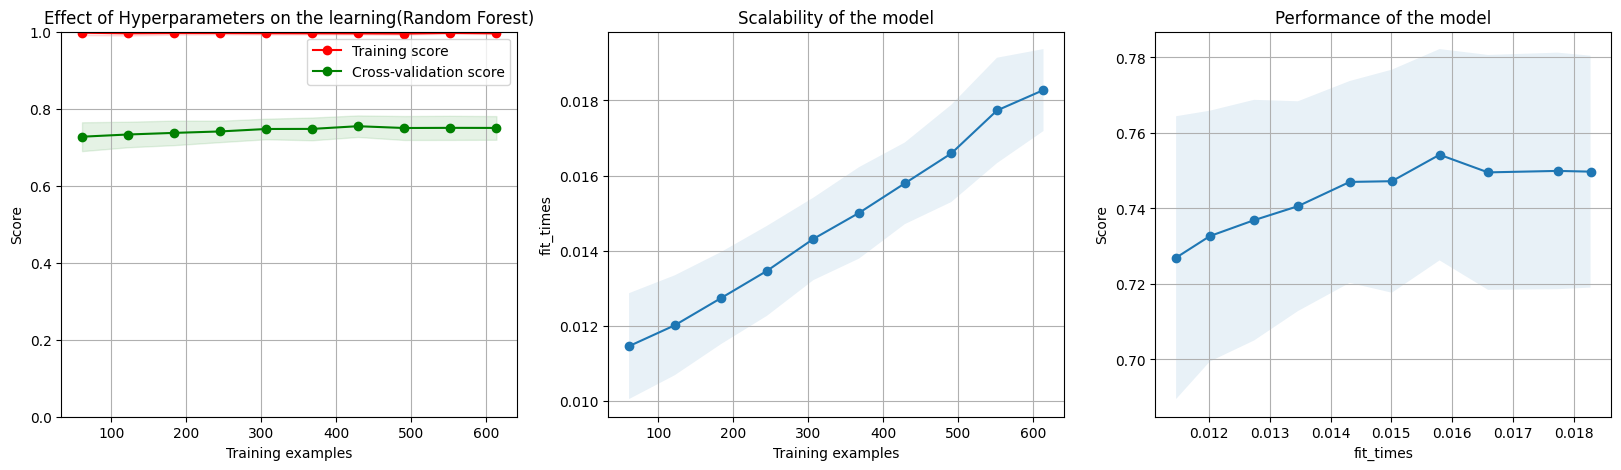

Hyperparameter curves have been generated and saved as 'Hyperparameter_curves.png'


In [ ]:


# Load the dataset (assuming we have a CSV file named 'diabetes_data.csv')
data = pd.read_csv('../Data files/diabetes_data.csv')

# Separate features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Create CV object
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# Create and train the model
rf_classifier = RandomForestClassifier(n_estimators=20, random_state=42)

# Plot learning curve
title = "Effect of Hyperparameters on the learning(Random Forest)"
plt = plot_hyperparameter_effect_curves(rf_classifier, title, X, y, cv=cv, n_jobs=4)
plt.show()
plt.savefig('Hyperparameter_curves.png')
plt.close()

print("Hyperparameter curves have been generated and saved as 'Hyperparameter_curves.png'")



---------------------------------------------------------------------------------------------------- 
feature importance for observation 20


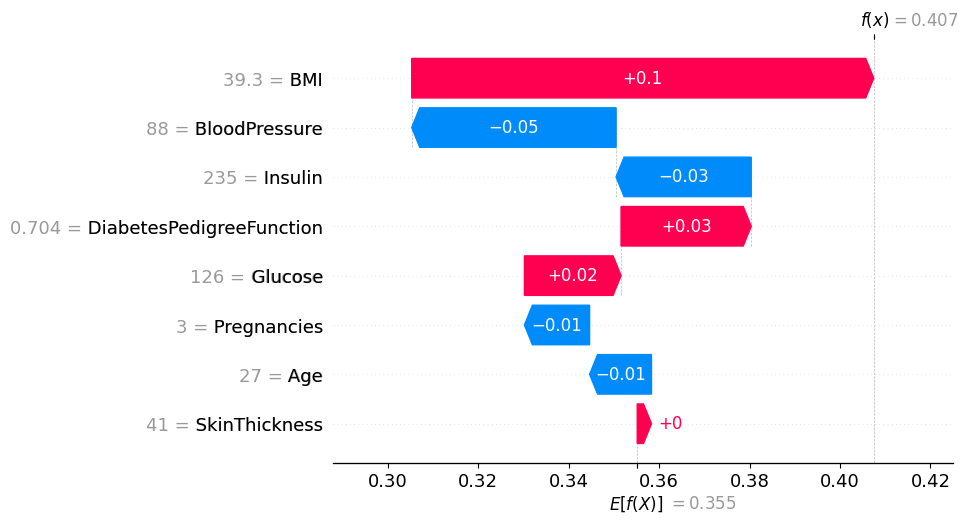

None
---------------------------------------------------------------------------------------------------- 
feature importance for observation 22


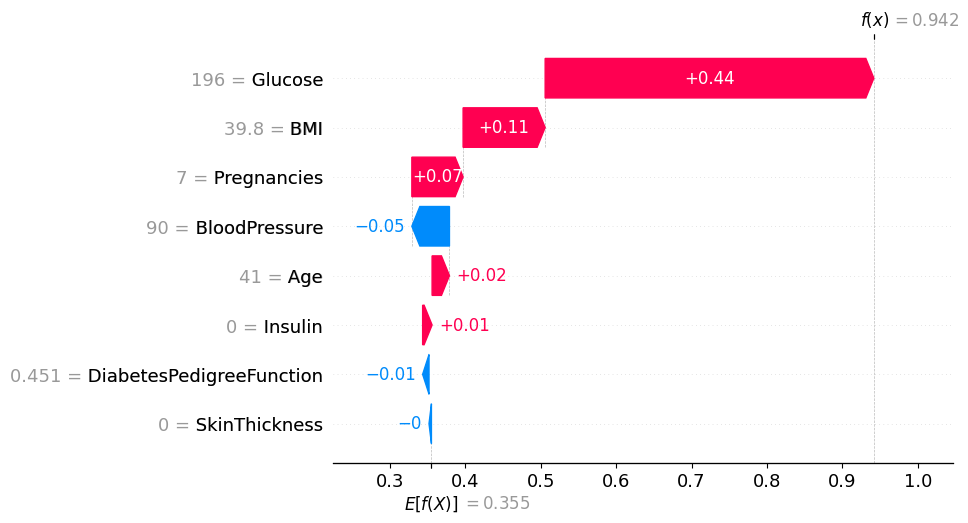

None
---------------------------------------------------------------------------------------------------- 
feature importance for observation 24


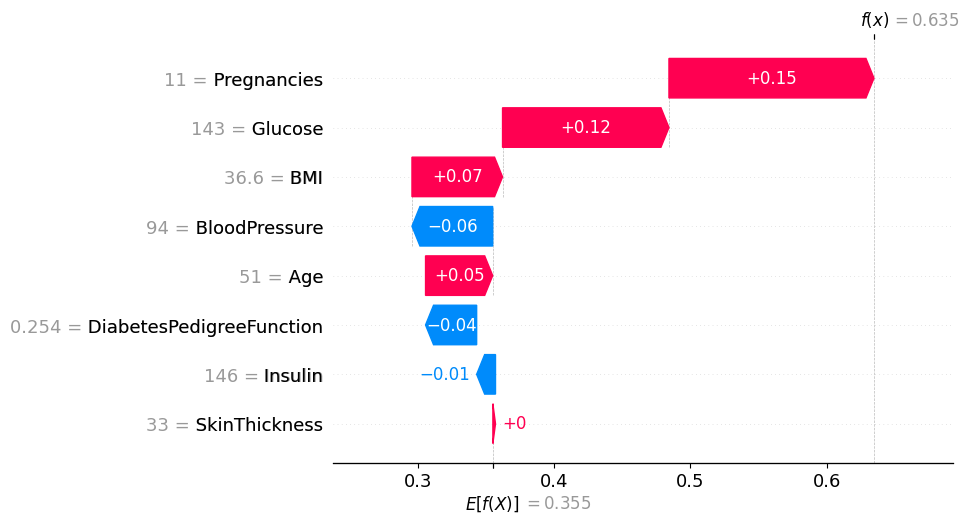

None
---------------------------------------------------------------------------------------------------- 
feature importance for observation 26


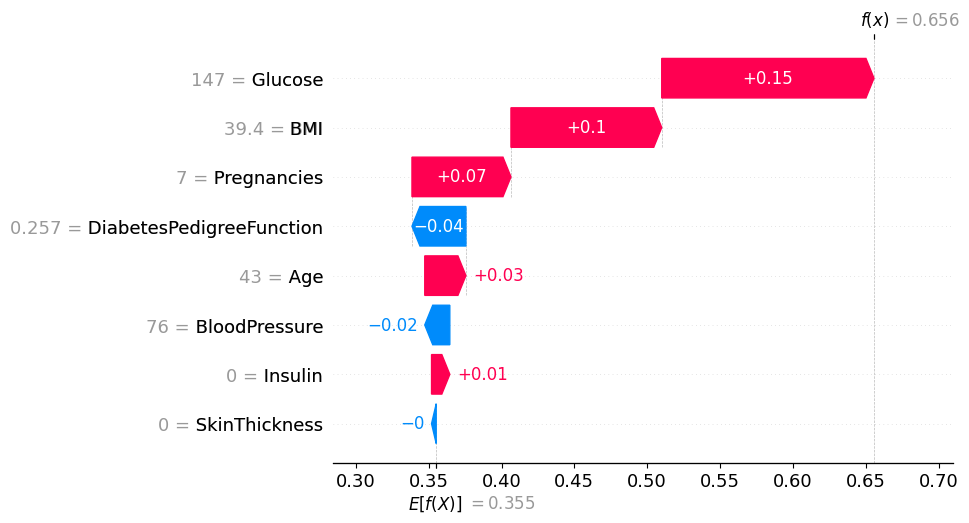

None


In [ ]:


model = LinearRegression()
model.fit(X, y)
title = "Shapely feature importance"

for i in (20, 22, 24, 26):
    print(f"{'-'*100} \nfeature importance for observation {i}")
    plot_shap_analysis(model, X, i)





---

## How do hyperparameters affect the model

#### max_deapth
- Controls how deep each tree can grow
- lower values = simpler trees

#### min_samples_split
- controls how large the node should be to allow split
- lower values = complex trees

#### min_samples_leaf
- controls maximum number of samples in each leaf
- higher the number = simpler tree

#### max_features
- controls how many number of features to look for to get the best split
- lower number = more random selection
- higher number = expensive calculation, slower model

#### bootstrap
- controls if the resampling should allow replacement

Parameter values being tested: [1, 2, 3, 4, 5, 6, 7, 8, 9]


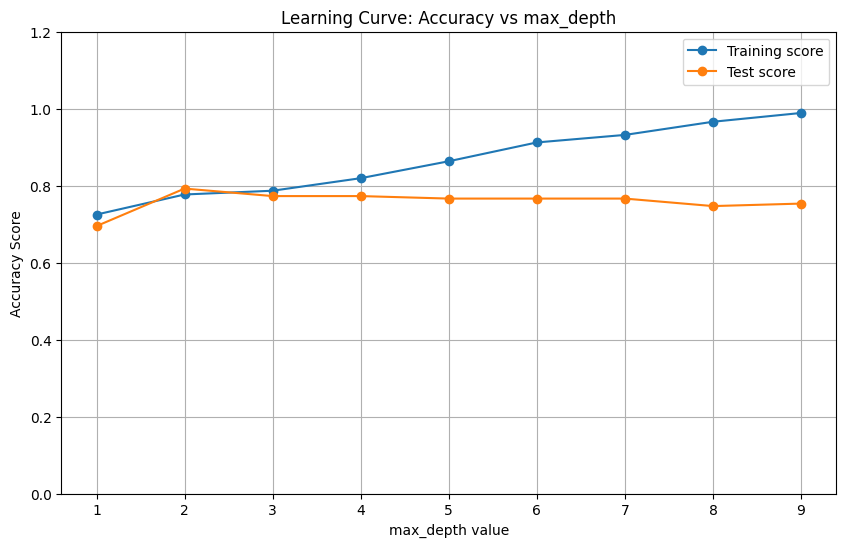

Parameter values being tested: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


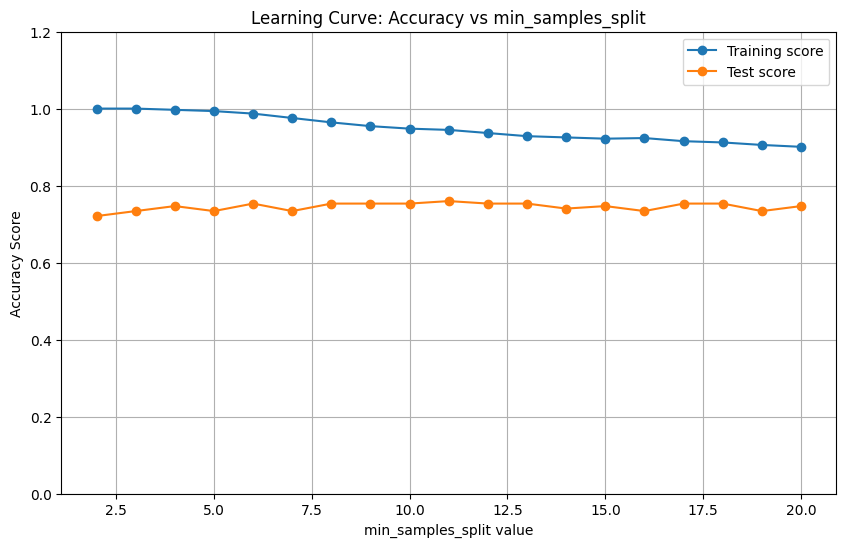

Parameter values being tested: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


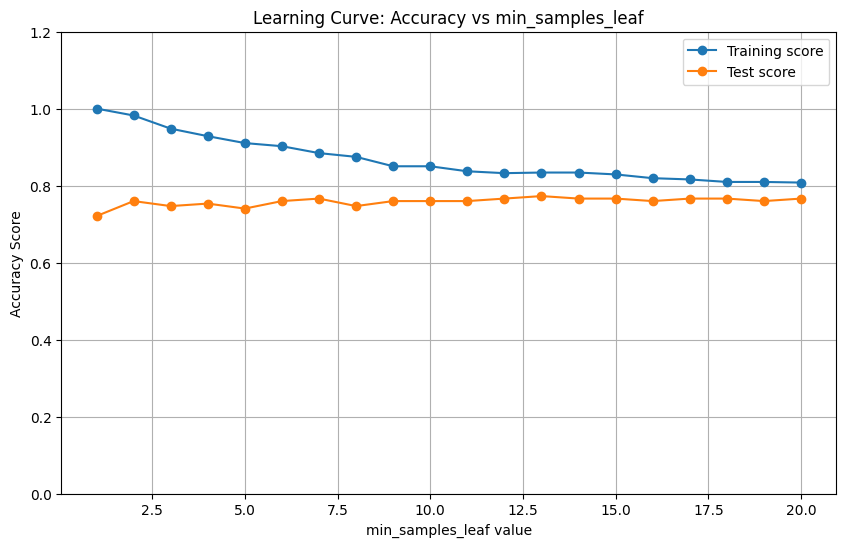

Parameter values being tested: ['sqrt', 'log2', 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0]


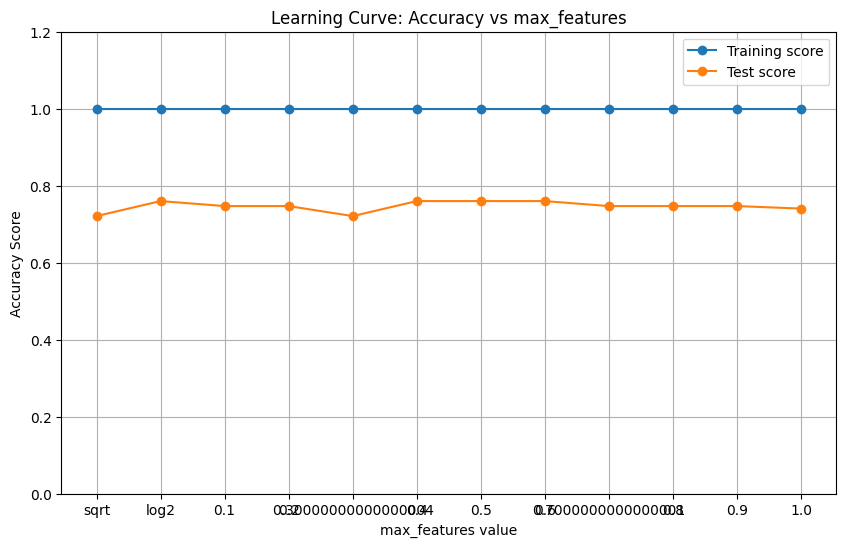

Parameter values being tested: [True, False]


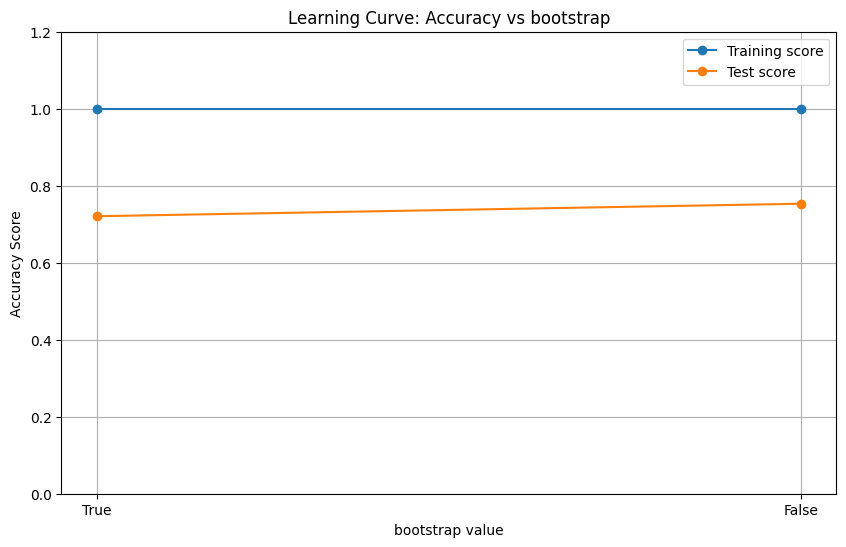

In [ ]:
def plot_learning_curve_hyperparameters(X, y, hyperparameter, param_range, n_estimators=100, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    train_scores = []
    test_scores = []

    # Convert param_range to list for indexing
    param_list = list(param_range)

    print(f"Parameter values being tested: {param_list}")  # Debug print

    for param_value in param_list:
        rf_params = {
            'n_estimators': n_estimators,
            'random_state': random_state,
            hyperparameter: param_value
        }
        rf = RandomForestClassifier(**rf_params)
        rf.fit(X_train, y_train)

        train_score = accuracy_score(y_train, rf.predict(X_train))
        test_score = accuracy_score(y_test, rf.predict(X_test))

        train_scores.append(train_score)
        test_scores.append(test_score)


    plt.figure(figsize=(10, 6))

    if isinstance(param_list[0], (str, bool)):
        x_range = range(len(param_list))
        plt.plot(x_range, train_scores, 'o-', label='Training score')  # Added markers
        plt.plot(x_range, test_scores, 'o-', label='Test score')      # Added markers
        plt.xticks(x_range, param_list)
    else:
        plt.plot(param_list, train_scores, 'o-', label='Training score')  # Added markers
        plt.plot(param_list, test_scores, 'o-', label='Test score')      # Added markers

    plt.xlabel(f'{hyperparameter} value')
    plt.ylabel('Accuracy Score')
    plt.title(f'Learning Curve: Accuracy vs {hyperparameter}')
    plt.legend()
    plt.ylim(0, 1.2)
    plt.grid(True)
    plt.show()

plot_learning_curve_hyperparameters(X, y, 'max_depth', range(1, 10))
plot_learning_curve_hyperparameters(X, y, 'min_samples_split', range(2, 21))
plot_learning_curve_hyperparameters(X, y, 'min_samples_leaf', range(1, 21))
plot_learning_curve_hyperparameters(X, y, 'max_features', ['sqrt', 'log2'] + list(np.arange(0.1, 1.1, 0.1)))
plot_learning_curve_hyperparameters(X, y, 'bootstrap', [True, False])

## 2 classes vs Multiclass problem

In [ ]:
import pandas as pd
data = pd.read_csv('../Data files/diabetes_dataset00.csv')
display(data.head())
display(data.shape)
# display(data.dtypes)
display(data.groupby(by='Target').size())


,Target,Genetic Markers,Autoantibodies,Family History,Environmental Factors,Insulin Levels,Age,BMI,Physical Activity,Dietary Habits,...,Pulmonary Function,Cystic Fibrosis Diagnosis,Steroid Use History,Genetic Testing,Neurological Assessments,Liver Function Tests,Digestive Enzyme Levels,Urine Test,Birth Weight,Early Onset Symptoms
0,Steroid-Induced Diabetes,Positive,Negative,No,Present,40,44,38,High,Healthy,...,76,No,No,Positive,3,Normal,56,Ketones Present,2629,No
1,Neonatal Diabetes Mellitus (NDM),Positive,Negative,No,Present,13,1,17,High,Healthy,...,60,Yes,No,Negative,1,Normal,28,Glucose Present,1881,Yes
2,Prediabetic,Positive,Positive,Yes,Present,27,36,24,High,Unhealthy,...,80,Yes,No,Negative,1,Abnormal,55,Ketones Present,3622,Yes
3,Type 1 Diabetes,Negative,Positive,No,Present,8,7,16,Low,Unhealthy,...,89,Yes,No,Positive,2,Abnormal,60,Ketones Present,3542,No
4,Wolfram Syndrome,Negative,Negative,Yes,Present,17,10,17,High,Healthy,...,41,No,No,Positive,1,Normal,24,Protein Present,1770,No


(70000, 34)

Target
Cystic Fibrosis-Related Diabetes (CFRD)       5464
Gestational Diabetes                          5344
LADA                                          5223
MODY                                          5553
Neonatal Diabetes Mellitus (NDM)              5408
Prediabetic                                   5376
Secondary Diabetes                            5479
Steroid-Induced Diabetes                      5275
Type 1 Diabetes                               5446
Type 2 Diabetes                               5397
Type 3c Diabetes (Pancreatogenic Diabetes)    5320
Wolcott-Rallison Syndrome                     5400
Wolfram Syndrome                              5315
dtype: int64

Original data shape: (70000, 34)

Numeric columns: ['Insulin Levels', 'Age', 'BMI', 'Blood Pressure', 'Cholesterol Levels', 'Waist Circumference', 'Blood Glucose Levels', 'Weight Gain During Pregnancy', 'Pancreatic Health', 'Pulmonary Function', 'Neurological Assessments', 'Digestive Enzyme Levels', 'Birth Weight']

Categorical columns: ['Target', 'Genetic Markers', 'Autoantibodies', 'Family History', 'Environmental Factors', 'Physical Activity', 'Dietary Habits', 'Ethnicity', 'Socioeconomic Factors', 'Smoking Status', 'Alcohol Consumption', 'Glucose Tolerance Test', 'History of PCOS', 'Previous Gestational Diabetes', 'Pregnancy History', 'Cystic Fibrosis Diagnosis', 'Steroid Use History', 'Genetic Testing', 'Liver Function Tests', 'Urine Test', 'Early Onset Symptoms']

Data Types Comparison:
                              Original  Cleaned
Target                          object    int32
Genetic Markers                 object    int32
Autoantibodies                  object    int32
Fami

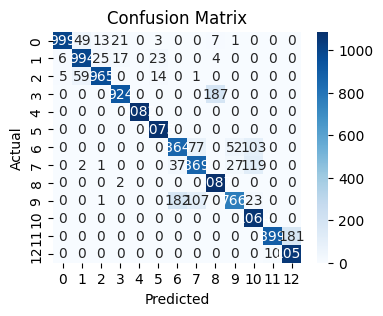


Traditional Feature Importance:
+----+-------------------------------+------------+
|    |            feature            | importance |
+----+-------------------------------+------------+
| 5  |              Age              |   0.1421   |
| 12 |     Blood Glucose Levels      |   0.1313   |
| 9  |        Blood Pressure         |   0.0851   |
| 21 | Weight Gain During Pregnancy  |   0.0797   |
| 29 |    Digestive Enzyme Levels    |   0.0768   |
| 6  |              BMI              |   0.0763   |
| 11 |      Waist Circumference      |   0.0696   |
| 4  |        Insulin Levels         |   0.0647   |
| 10 |      Cholesterol Levels       |   0.0593   |
| 23 |      Pulmonary Function       |   0.0538   |
| 31 |         Birth Weight          |   0.0477   |
| 22 |       Pancreatic Health       |   0.0312   |
| 27 |   Neurological Assessments    |   0.0164   |
| 30 |          Urine Test           |   0.006    |
| 16 |      Alcohol Consumption      |   0.0049   |
| 14 |     Socioeconomic Factor

In [ ]:
# Multiclass

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler



def clean_data(file_path):
    # Load the data
    data = pd.read_csv(file_path)
    print("Original data shape:", data.shape)
    # print("\nOriginal data types:")
    # print(data.dtypes)
    original_dtypes = pd.DataFrame(data.dtypes, columns=['Original'])


    # Function to check if a column is numeric
    def is_numeric(col):
        try:
            pd.to_numeric(data[col], errors='raise')
            return True
        except ValueError:
            return False

    # Identify numeric and categorical columns
    numeric_columns = [col for col in data.columns if is_numeric(col)]
    categorical_columns = [col for col in data.columns if col not in numeric_columns]

    print("\nNumeric columns:", numeric_columns)
    print("\nCategorical columns:", categorical_columns)

    # Handle missing values
    numeric_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    data[numeric_columns] = numeric_imputer.fit_transform(data[numeric_columns])
    data[categorical_columns] = categorical_imputer.fit_transform(data[categorical_columns])

    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_columns:
        data[col] = le.fit_transform(data[col].astype(str))

    # Scale numeric features
    scaler = StandardScaler()
    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    # print("\nCleaned data types:")
    # print(data.dtypes)
    final_dtypes = pd.DataFrame(data.dtypes, columns=['Cleaned'])
    dtype_comparison = pd.concat([original_dtypes, final_dtypes], axis=1)

    print("\nData Types Comparison:")
    print(dtype_comparison)

    # Create the cleaned file path in the same directory as the original file
    original_dir = os.path.dirname(file_path)
    original_filename = os.path.basename(file_path)
    cleaned_filename = 'cleaned_' + original_filename
    cleaned_file_path = os.path.join(original_dir, cleaned_filename)

    # Save the cleaned data
    data.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned data saved to {cleaned_file_path}")

    return data, cleaned_file_path



# Load the dataset (assuming we have a CSV file named 'multiclass_health_data.csv')
data, cleaned_file_path = clean_data('../Data files/diabetes_dataset00.csv')



# Separate features and target
X = data.drop('Target', axis=1)  # Assuming 'HealthStatus' is the target column
y = data['Target']

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)
unique_classes = [str(cls) for cls in range(len(le.classes_))]
print("\nUnique classes:", unique_classes)



# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create CV object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train the model on the full training set
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=unique_classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_classifier.classes_)
plt = print_confusion_matrix(cm)
plt.show()
plt.close()


# Feature importance
plt = print_feature_importance(X, rf_classifier.feature_importances_)
plt.show()
plt.close()

print("\nFeature importance plot has been saved as 'feature_importance_multiclass.png'")

print("\nMulticlass classification analysis completed successfully!")

---

## Ways to Systematically Automate Model development

In [ ]:
from pycaret.classification import setup, ClassificationExperiment


# Set up data and project
data = pd.read_csv('../Data files/diabetes_dataset00.csv')
data = data.iloc[0:1000,]
s = ClassificationExperiment()
s.setup(data, target = 'Target', session_id=123, log_experiment=True)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Multiclass
3,Target mapping,"Cystic Fibrosis-Related Diabetes (CFRD): 0, Gestational Diabetes: 1, LADA: 2, MODY: 3, Neonatal Diabetes Mellitus (NDM): 4, Prediabetic: 5, Secondary Diabetes: 6, Steroid-Induced Diabetes: 7, Type 1 Diabetes: 8, Type 2 Diabetes: 9, Type 3c Diabetes (Pancreatogenic Diabetes): 10, Wolcott-Rallison Syndrome: 11, Wolfram Syndrome: 12"
4,Original data shape,"(1000, 34)"
5,Transformed data shape,"(1000, 43)"
6,Transformed train set shape,"(700, 43)"
7,Transformed test set shape,"(300, 43)"
8,Numeric features,13
9,Categorical features,20


In [ ]:
best = clf.compare_models(include = ['nb','lr','svm'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.8236,0.9893,0.8236,0.8246,0.8233,0.8089,0.8090,0.3350
lr,Logistic Regression,0.7090,0.0000,0.7090,0.7082,0.7082,0.6847,0.6848,2.5760
svm,SVM - Linear Kernel,0.4911,0.0000,0.4911,0.6671,0.4619,0.4488,0.4749,1.3690


2024/11/07 14:08:04 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.17.2, required: mlflow==2.16.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/07 14:08:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/07 14:08:04 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.17.2, required: mlflow==2.16.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/11/07 14:08:04 WARN

In [ ]:
from pycaret.regression import plot_model
plot_model(best_model, plot = 'residuals_interactive')


In [ ]:
!pip uninstall mldlow

In [ ]:
import mlflow
print(mlflow.__version__)

2.16.2


**Please restart session using Runtime >> Restart session (CTRL + M)** :



---

# Goals
### At the end of this hour, we would have achieved following goals -  

1.   Get hands dirty with Google Colab Notebooks
2.   Have a better understanding of the broader AI/ML activities
3.   Got to see the data cleaning process
4.   Completed a run of a realistic AI/ML experiment
5.   Completed a run of a realistic AI/ML experiment with AutoML
6.   Have a better understanding of what artifacts to save/submit to FDA




# 3000 ft View of Machine learning in production

Machine learning / AI in production is a complex orchestra and iterative process. The orchestration of "other" activities happens around each Machine learning experiment which is at the core. Today will look at the experiment itself and try to simplify it. The objective for this presentation is for all of us to be able to actually complete an experiment and feel comfortable with the basics of a Machine learning project.

For this experiment, the business understanding, problem statement, KPI for success, and appropriation of time and money has been completed. Therefore, we start with the data.

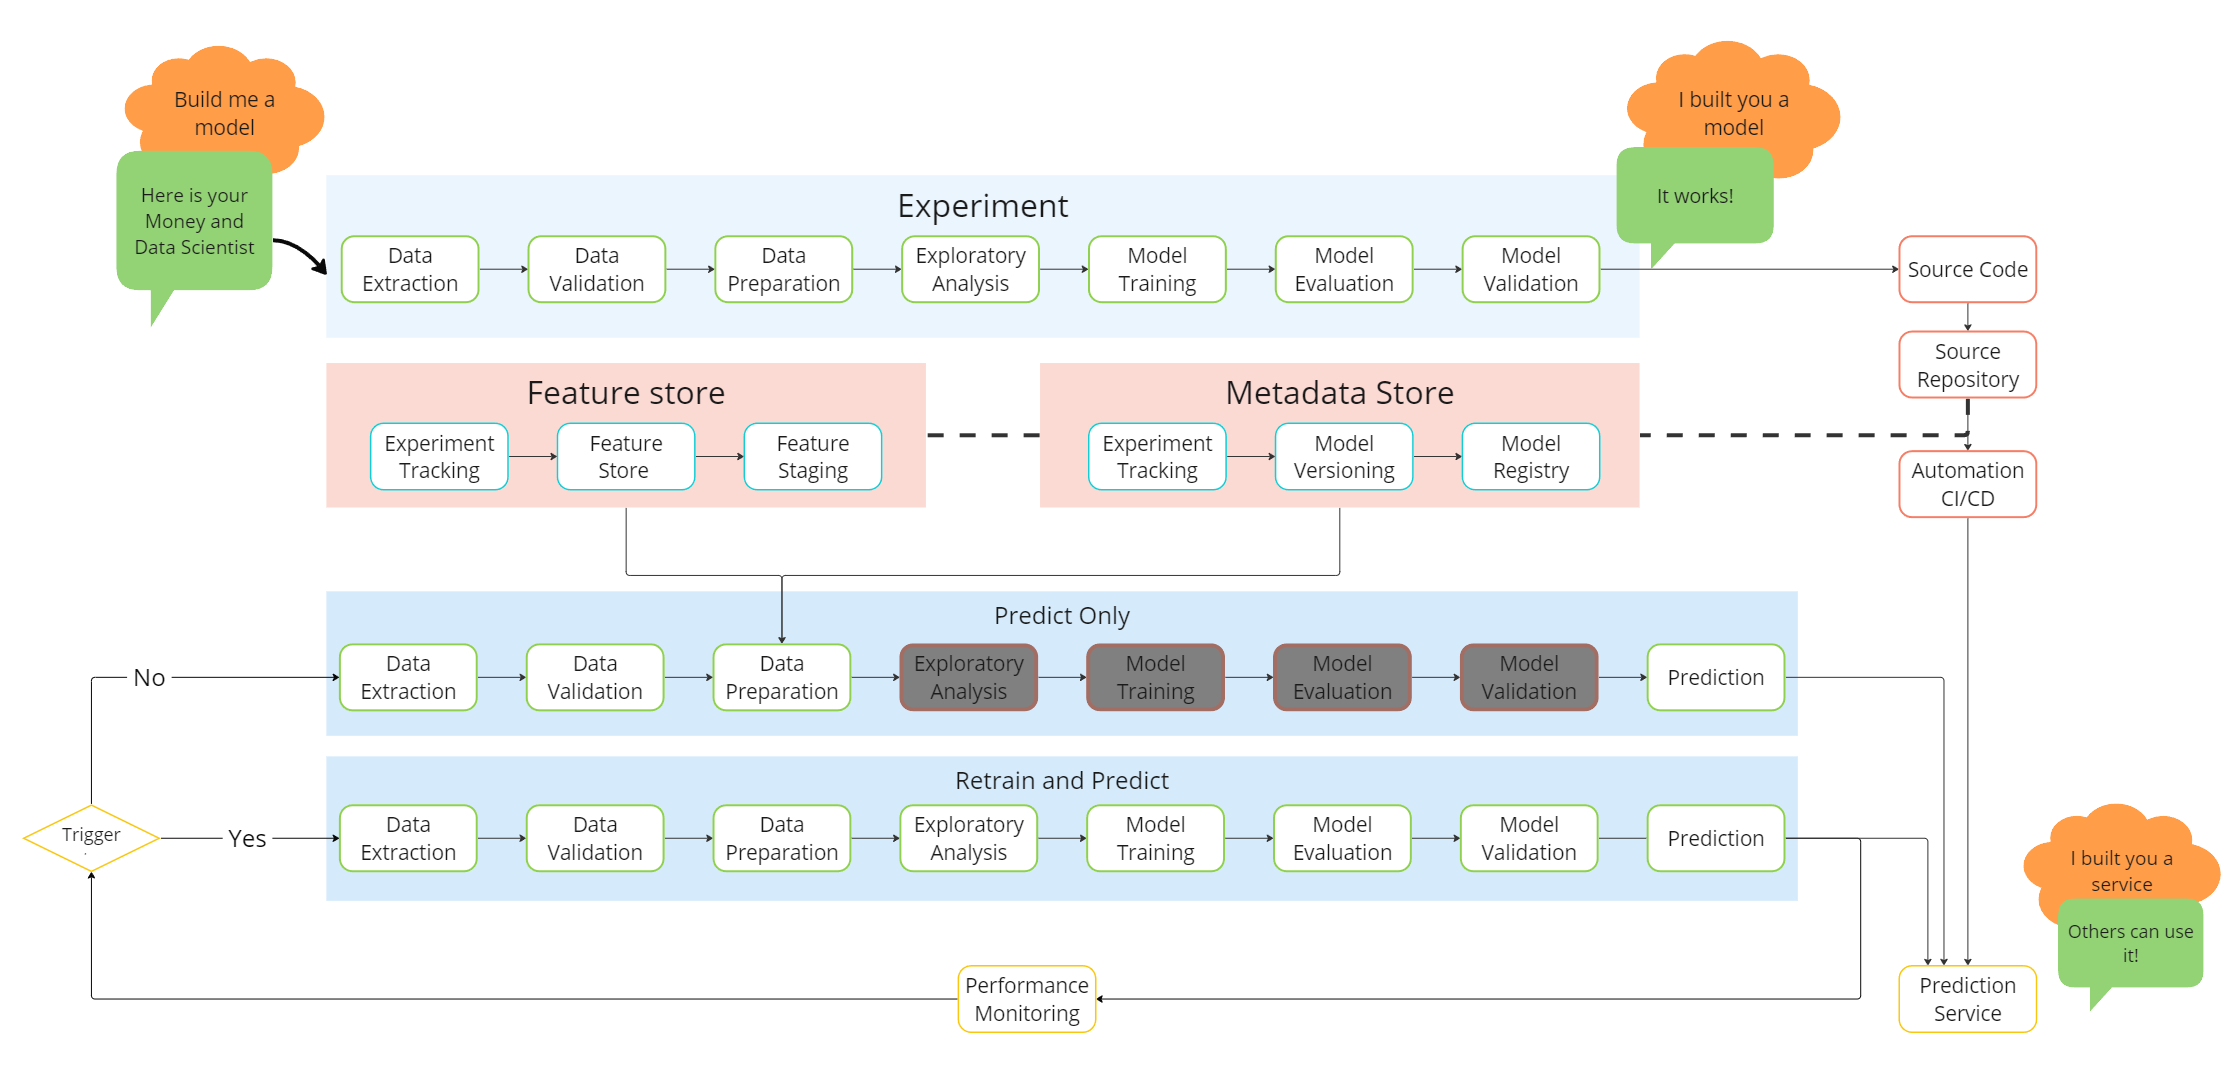

## Today we focus on Model Building
Assuming that the data has been collected and validated. Now we need to -

1. prepare data
2. understand the data using Exploratory data analysis
3. train a model or multiple models
4. evaluate our model choice
5. validate the model against data that was not used during the training/testing to simulate real-life performance.

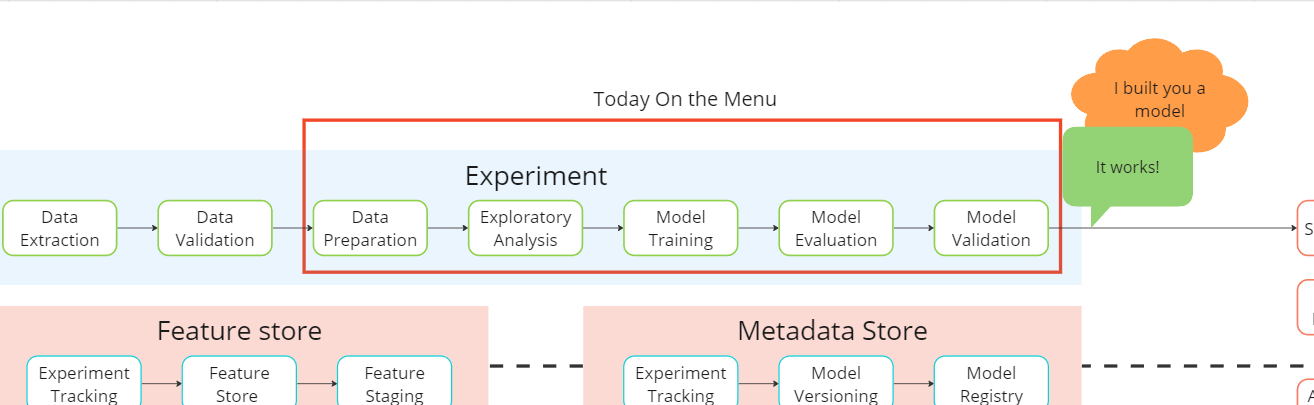








## Importing libraries for running this experiment.
The libraries are grouped by their purpose.


1.   Reading the data
2.   Understanding and profiling the data
3.   Machine learning - model development
4.   Machine learning - performance measurement
5.   Other libraries to make our life easy

In [ ]:
# import packages

# Reading the data in -
import numpy as np
import pandas as pd

# Profiling the data through Exploeratory data analsis
import seaborn as sns
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport
import missingno as msno
from sklearn.impute import SimpleImputer

# Machine learning - model development
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Machine larning - performance measurement
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats

# Otehr libraries
import warnings
warnings.filterwarnings('ignore')
from google.colab import data_table
data_table.enable_dataframe_formatter()


# Understanding our data - Profiling it - Fixing it

In [ ]:
# Reading the data
data = pd.read_csv('diabetes_data.csv')

# Understanding how the data looks
display(data.head(n=10))
display('-'*100)

# How large is the data?
display(f'The data has {data.shape[1]} columns, and {data.shape[0]} rows')
display('-'*100)

# What are the columns in the data
display(f'Column names: {", ".join(list(data.columns))}')
display('-'*100)

# what is the format of data
display(pd.DataFrame({"column-name": data.columns,
              "non-nulls": len(data)-data.isnull().sum().values,
              "nulls": data.isnull().sum().values,
              "type": data.dtypes.values}))

In [ ]:
profile = ProfileReport(data,
                        title="Profiling Report",
                        dark_mode = True,
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile before cleaning.html')

## Folks we have a missingness problem

Blood Pressure, Skin thickness, Insuling levels, BMI, Glucose levels, and Age of ZERO are incompatible with life! That means we have a problem.

We have to fix it -

### We have a few options
*   We can check which patients did we have the least data on -
*   We can check if the missingness is real and then decide if we want to -
  - remove those observations
  - remove those features (variables)
  - replace/impute those variables



## Fixing ZERO and Missing values

### First, we will replace all zeros to missing values
* we have some good packages to investigate missingness (and I am lazy ;) )


In [ ]:
# data.update(data[['Pregnancies','BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']].replace(0, np.nan, inplace=True))
data_cleaned = data.copy()
for i in ['BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']:
  data_cleaned[i].replace(0, np.nan, inplace=True)


In [ ]:
# Lets find percent missingness in the data for each variable
missingness_sorted = sorted(pd.DataFrame(data_cleaned.isna().sum()).to_dict()[0].items(), key=lambda x: -x[1])
list(map(lambda x: (x[0], round(x[1]/data_cleaned.shape[0]*100, 2)), missingness_sorted))

In [ ]:
# Further investigate missing numbers to check which missing variables always go together
print("missingness correlation between variables")
msno.heatmap(data_cleaned, figsize=(6,4), fontsize=10)
print("-"*100 + "\n")

## Decision time! We are keeping Insulin
* Insulin missing for 48.7% observations was heartbreaking
* Skin thickness was also missing for approximately 30% observations
* Clinically I hate to see Insulin missing for a diabetes dataset but thats life!

In [ ]:
# imputing all missing values with mean fore all columns
simple_imputed_data = data_cleaned.copy()
for i in ['BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']:
  # Start the imputer engine and tell it that missing values are noted by NaN values and it has to use the 'mean' of all other values to fill in as a strategy.
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

  # Input the real data for each column to the imputer engine so that it can calculate what needs to be imputed.
  imputer =  imputer.fit(simple_imputed_data[[i]].values)

  # Replace the old columne with the new column of imputed NaN with mean.
  simple_imputed_data[i] = imputer.transform(simple_imputed_data[[i]].values)


# Lets rerun profile report again
profile = ProfileReport(simple_imputed_data,
                        title="Profiling Report",
                        dark_mode = True,
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile after simple imputation.html')


In [ ]:

# Lets see the difference between original data and the new data

print('Original data with Zeros')
display(data.head())
print('Original data with suspected zeros replaced with NaN')
display(data.head())
print('Imputed data with NaN replaced with mean')
display(simple_imputed_data.head())

That was a ridiculous distribution!

We need a better way to fix missingness.
Lets try another imputer. This time we will use other columns to inform value at the missing observation.

However, we need to first remove the outcome from the data so that we dont impute using the outcome!

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Lets create a new copy of the cleaned data (the one with the NaNs)
multi_imputed_data = data_cleaned.copy()

# Lets remove the influence of the outcome from the imputations - otherwise we are fitting the imputed values based on the outcome. This is information leakage
multi_imputed_data_outcome = multi_imputed_data[['Outcome']]
multi_imputed_data.drop(columns = ['Outcome'], inplace=True)

# Lets impute
imputer = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=0)
imputer.fit(multi_imputed_data.values)
multi_imputed_data = pd.DataFrame(imputer.transform(multi_imputed_data), columns=multi_imputed_data.columns)

# Putting togetherFinal dataframe by adding back the outcomes
Finaldata = pd.concat([multi_imputed_data, multi_imputed_data_outcome], axis = 1)
Finaldata.head()

# Lets rerun profile report
profile = ProfileReport(Finaldata,
                        title="Profiling Report",
                        dark_mode = True,
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile after multiple imputation.html.html')



---

**Lets move to the next step**

---


# Data Cleaning is completed! Let's model

### There are so many algorithms to select from (Cheatsheet)
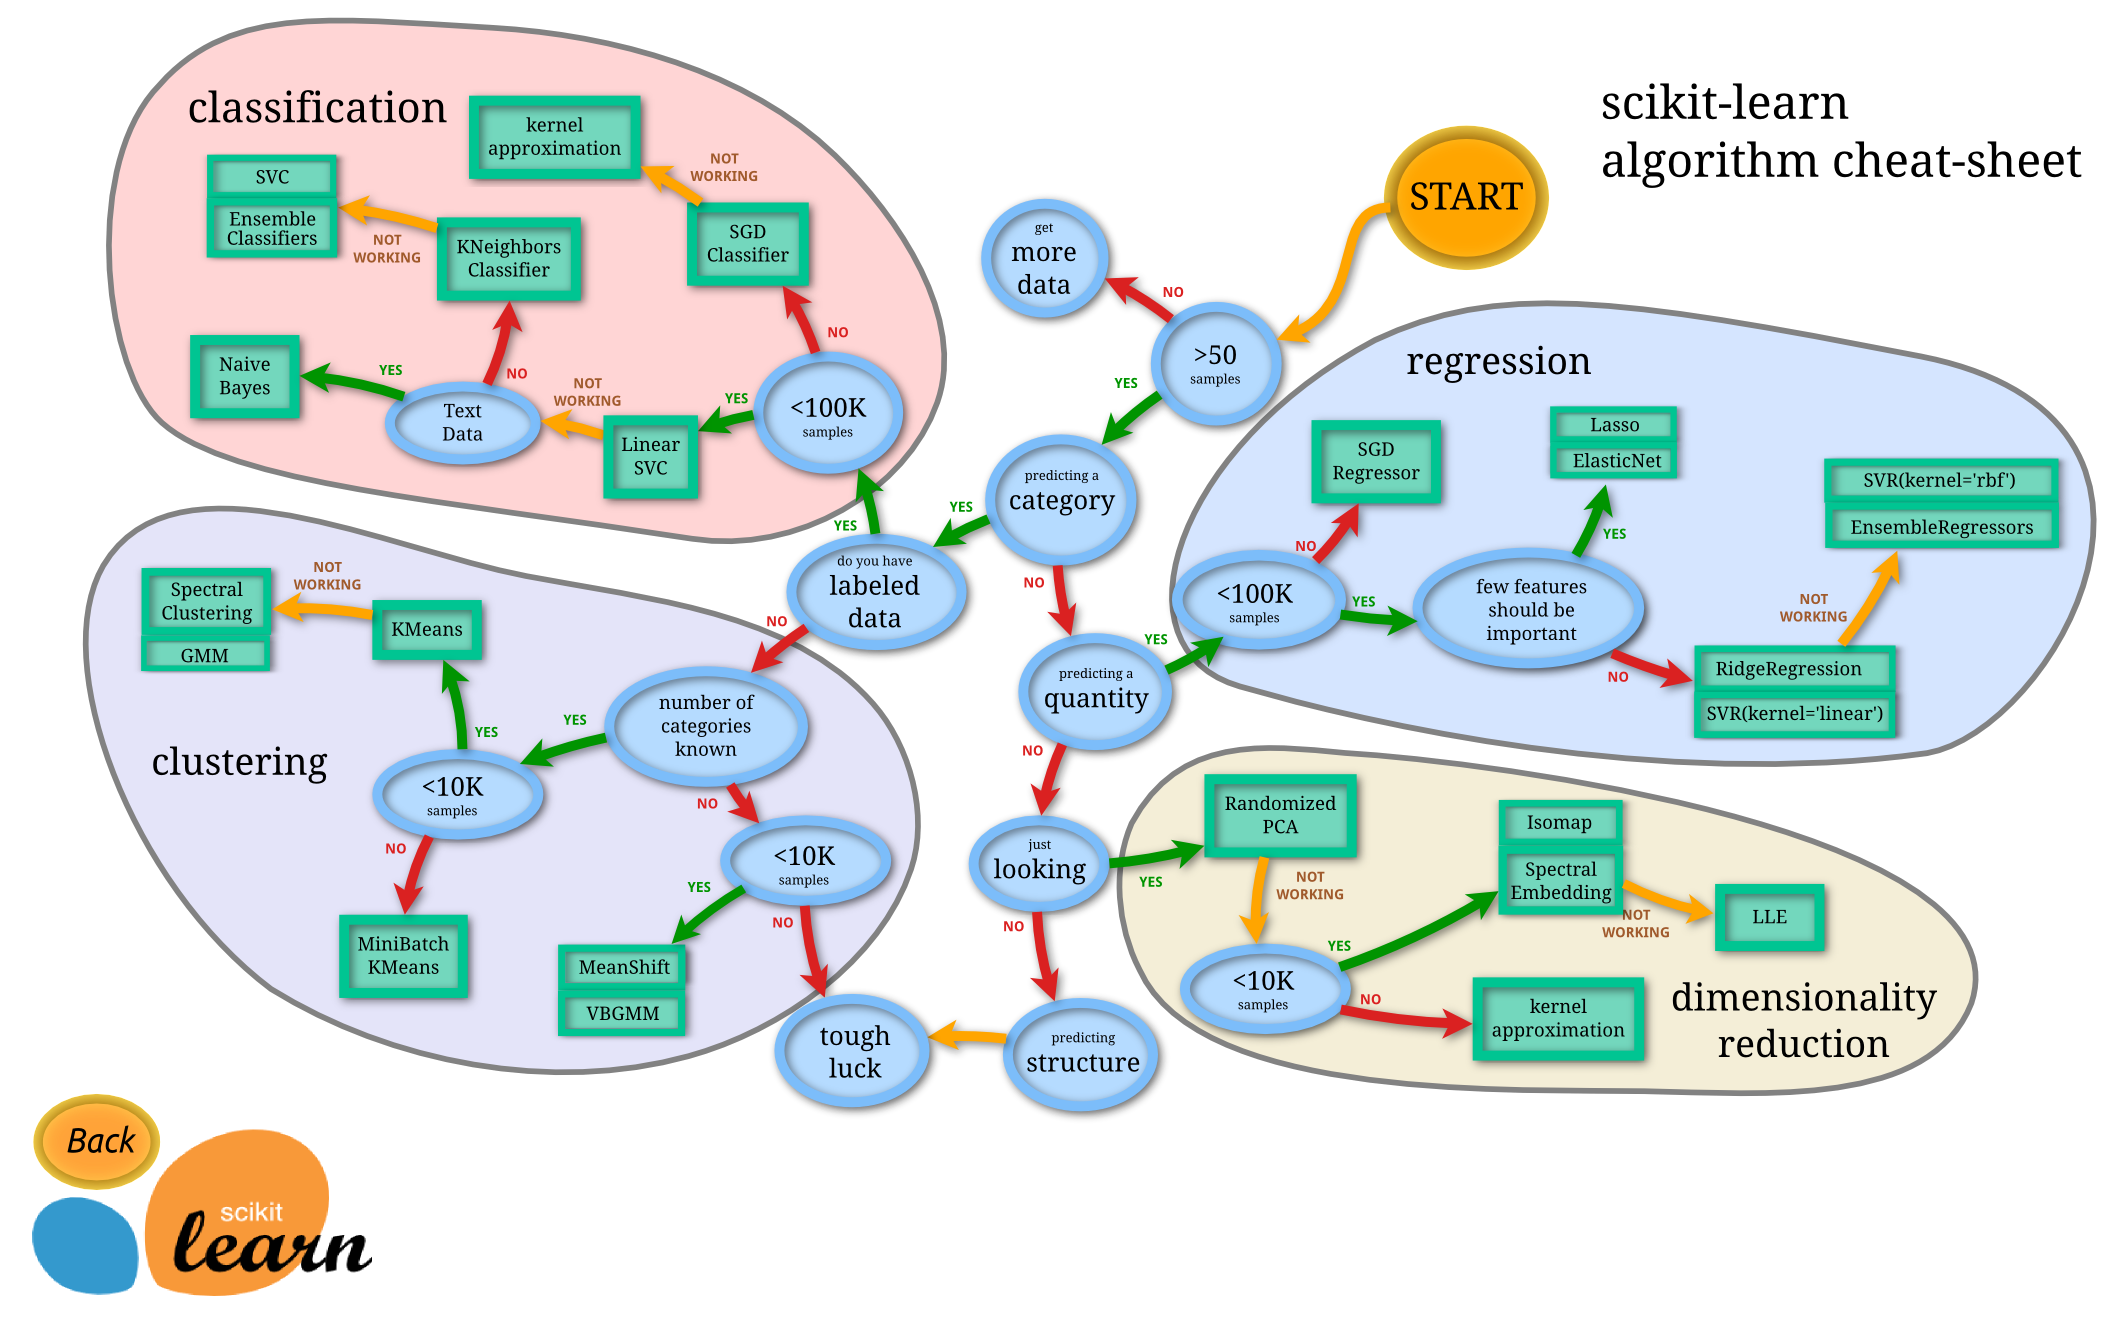

## Lets try one of the many choices

We will use `KNeighborsClassifier` for our first Wrong model choice!

KNeighborsClassifier is an algorithm that effectively categorizes data points according to the trends found in that said point's nearest data points or neighbors.

Frist we need to standardize and scale the data. StandardScaler removes the mean and scales each feature/variable to unit variance. Having unit (1) variance makes all variables to have the same influence over the outcome.

Then we split the data into training and testing data.
Training data will be used to train the model while testing data will be used to test the accuracy model.

In [ ]:
from sklearn.preprocessing import StandardScaler
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# Standardize the data set
scaler = StandardScaler()
scaler.fit(Finaldata.drop('Outcome', axis=1))
scaled_features = scaler.transform(Finaldata.drop('Outcome', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = Finaldata.drop('Outcome', axis=1).columns)



# Split the data set into training data and test data
x = scaled_data
y = Finaldata['Outcome']
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.1, random_state=9999)




# Train the model and make predictions
model = KNeighborsClassifier(n_neighbors = 5, weights='distance')
model.fit(x_training_data, y_training_data)
predictions = model.predict(x_test_data)




# Performance measurement in training data
print(f"Confusion matrix in training data: \n{classification_report(y_training_data, model.predict(x_training_data))}")
print('-'*100)
print('How well did we do on the training data?')
fig, ax = plt.subplots(figsize=(3,3))
cmp = ConfusionMatrixDisplay.from_estimator(model, x_training_data, y_training_data, ax=ax)
plt.show()
print('-'*100)




# Performance measurement in test data
print(f"Confusion matrix in testing data: \n{classification_report(y_test_data, predictions)}")
print('-'*100)
print('How many wrong predictions are we creating?')
fig, ax = plt.subplots(figsize=(3,3))
cmp = ConfusionMatrixDisplay.from_estimator(model, x_test_data, y_test_data, ax=ax)
plt.show()

print('-'*100)




In [ ]:
#Selecting an optimal K value
print('What is the right number of neighbors?')
error_rates = []
accuracy_scores = []
f1_scores = []
for i in np.arange(1, 100):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))
    accuracy_scores.append(accuracy_score(y_test_data, new_predictions))
    f1_scores.append(f1_score(y_test_data, new_predictions))

plt.figure()
plt.plot(f1_scores, label="f1_scores")
plt.plot(accuracy_scores, label="accuracy_scores")
plt.show()


We just completed a model creation pass (an experiment) and predicted the outcomes. And even quickly dipped our toes in the hyperparameter tuning.!!


## Which classificatiom model is the best one though!

Lets run a loop over all models that we could find and run an experiment.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Linear SVM",
    "QDA",
    "Naive Bayes",
    "Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    SVC(kernel="linear", C=0.025, random_state=42),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),

    KNeighborsClassifier(3),
    SVC(gamma='auto', C=1, degree = 1, random_state=22),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
]

figure = plt.figure(figsize=(40, 4))
i = 1

# preprocess dataset, split into training and test part
x= Finaldata[['Glucose', 'BMI']]

# Create a data of the outcomes
y= Finaldata['Outcome']

X, y = x.to_numpy(), y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):

    ax = plt.subplot(1, len(classifiers) + 1, i)
    ax.set_title(names[i-2])

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot the training points
    ax.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    i += 1

plt.tight_layout()
plt.show()

## Comparing the Accuracy metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Linear SVM",
    "QDA",
    "Naive Bayes",
    "Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    SVC(kernel="linear", C=0.025, random_state=42 , probability=True),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),

    KNeighborsClassifier(3),
    SVC(gamma='auto', C=1, degree = 1, random_state=22, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
]

# preprocess dataset, split into training and test part
x = Finaldata[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Create a data of the outcomes
y = Finaldata['Outcome']

X, y = x.to_numpy(), y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


for name, clf in zip(names, classifiers):

  clf = make_pipeline(StandardScaler(), clf)
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)

  y_pred_proba = clf.predict_proba(X_test)[::,1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr,tpr,label=f"{name}, auc="+str(round(auc,3)))
  plt.legend(loc=4)

plt.show()




---
---






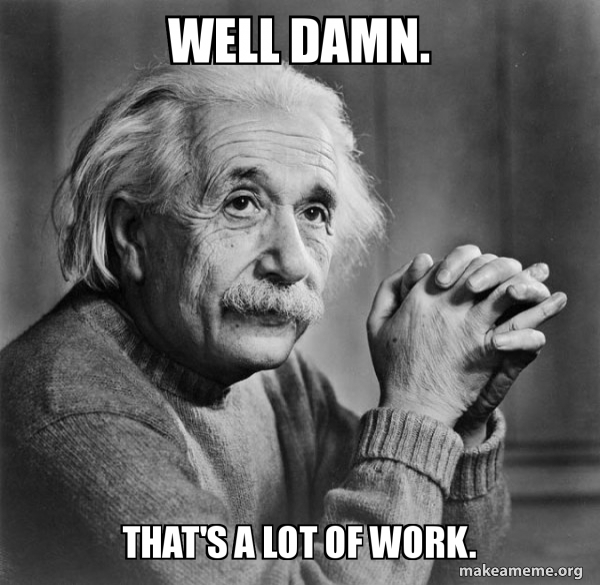

# AutoML

## only Carets, No sticks
#### Lets make our life easier by using completely OpenSource projects like PyCaret

In [ ]:
# Import library
from pycaret.classification import *

# Set up data and project
clf = setup(Finaldata, target = 'Outcome', session_id=123, log_experiment=True, experiment_name='juice1')

## Selecting and evaluating the best model

In [ ]:
# Let the data choose the best model
best_model = clf.compare_models()

In [ ]:
# Let the caret show us the evaluation results for the best model
evaluate_model(best_model)

In [ ]:
# Check fairness of the model based on Pregnancies (Is the model less accurate for Pregnant people?)
check_fairness(best_model, sensitive_features = ['Pregnancies'])

## But I want to try out one of the Non-best models


In [ ]:
# But I want to try out one of the Non-best models

# Get the model
model = create_model('lightgbm')

# Evaluate it
evaluate_model(model)

# Check fairness
fairness = check_fairness(model, sensitive_features = ['Pregnancies'])

In [ ]:
model.get_params()

# What does it mean for submission process?

In [ ]:
# Import library
from pycaret.classification import *

# Set up data and project
clf = setup(Finaldata, target = 'Outcome', session_id=123, log_experiment=True, experiment_name='juice1')
best_model = clf.compare_models()
best_auc_model = automl(optimize = 'AUC')

In [ ]:
best_auc_model.get_params()

# Where does it fit the Regulatory Framework?

### Process standards
* ISO 13585
* ISO 14971
* IEC 62366
* IEC 62304

### Generic Product Standards examples
* IEC 60601-1
* IEC 60601-1-2 EMC
* IEC 60601-1-6 Usability


### Product standard example
* IEC 60601-2-10 Safety of Tissue stimulators
* IEC 60601-1-2-57 Non-laser light source equipment
* IEC 62471 Photobiological Safety of Lamps

### MDR--------- etc. etc.


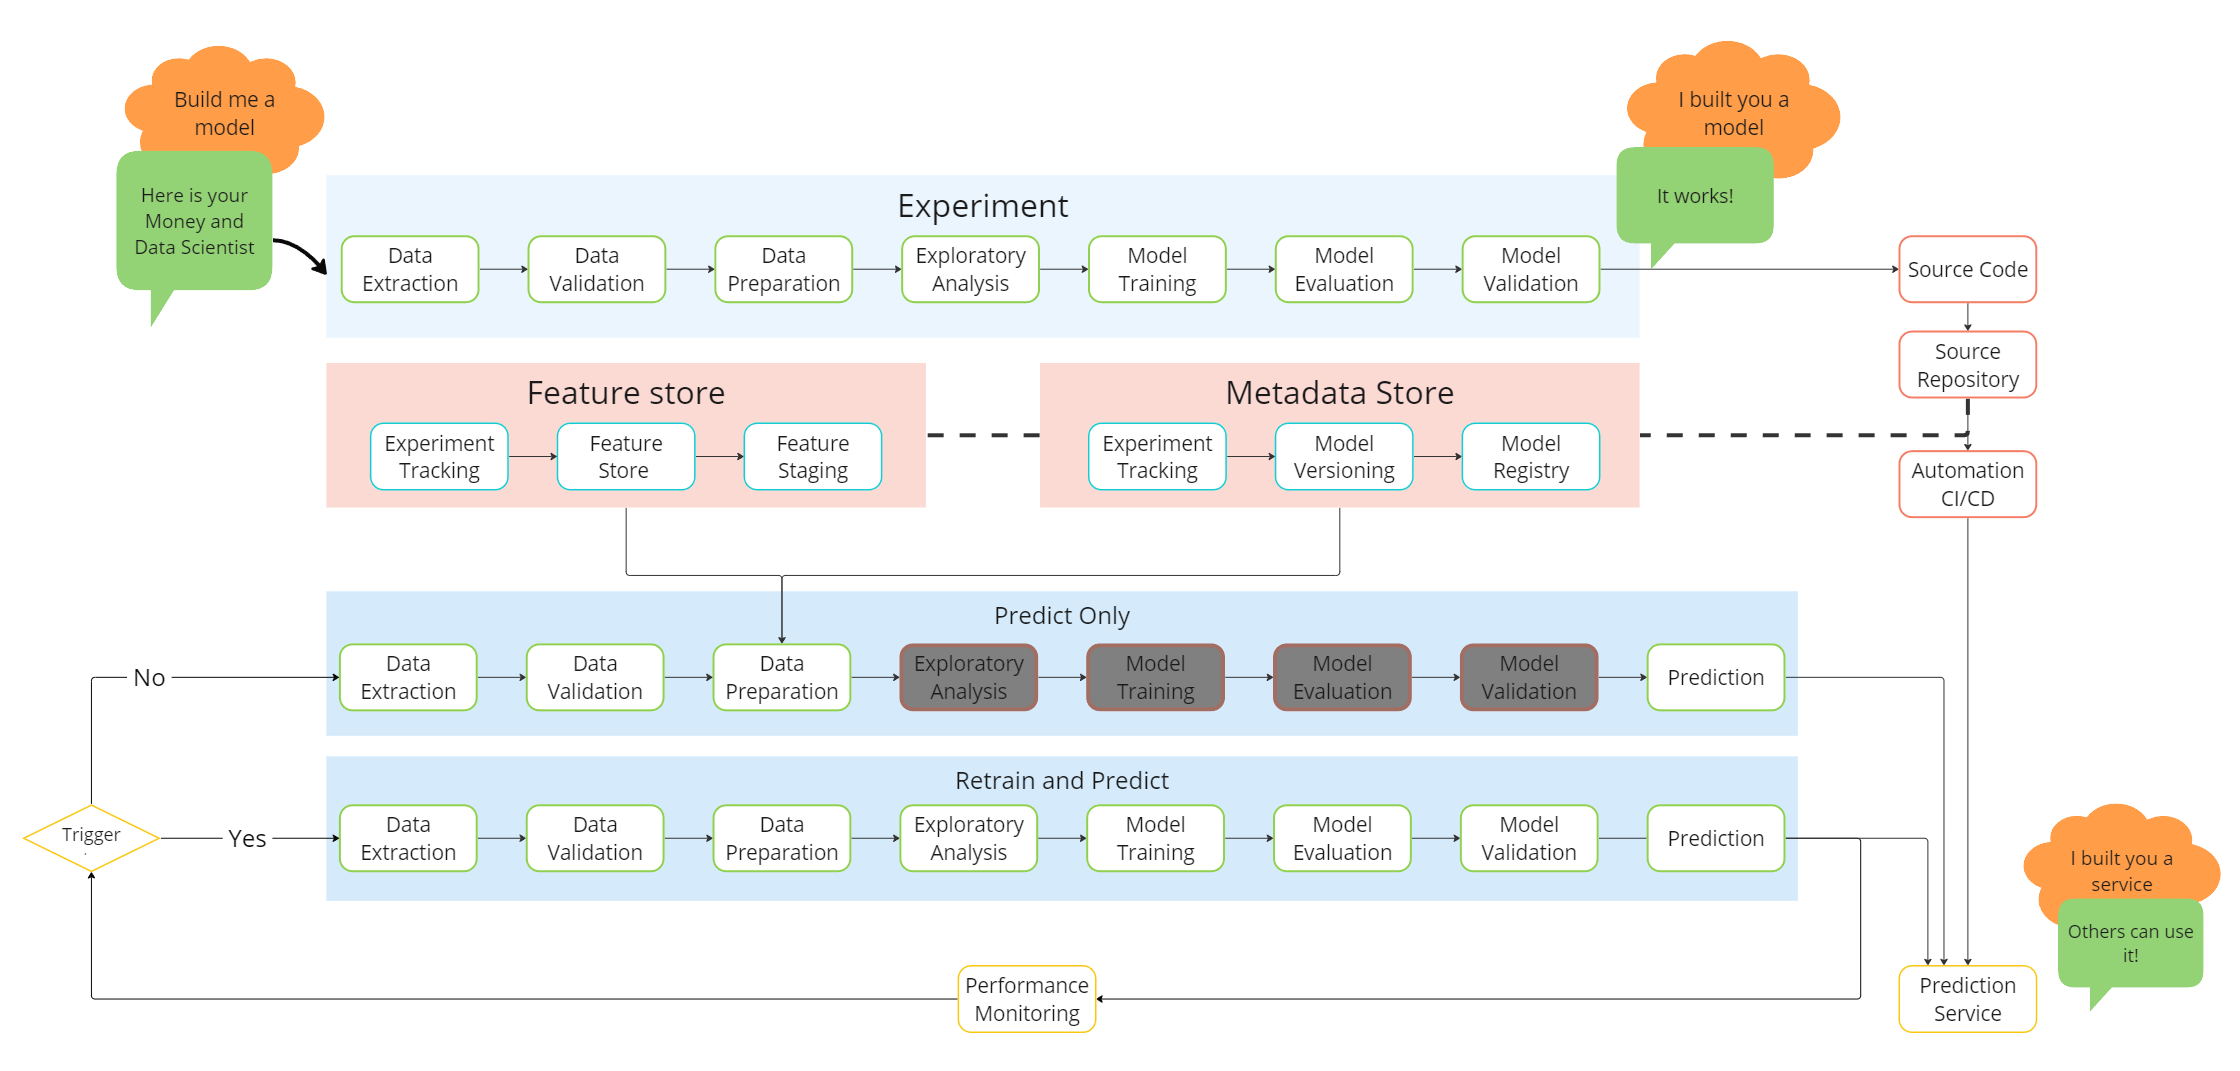

## Lets focus only on Software development aspect
Algorithm is a part of the software development process. All the due diligence necessary for

    Part 5: Software development process.
    Part 6: Software maintenance process.
    Part 7: Software risk management process.
    Part 8: Software configuration management process.
    Part 9: Software problem resolution process.

A proper architecture in the image above will help you have the information upfront. It is highly recommended to get the software developers and data scientists involved in the process from the regulatory point of view.

* Early Regulatory Socialization: Make developers and scientists familiar with specific instructions / "places where most common mistakes happen" like EC TR 80002-1:2009, ISO14971 and requirements of IEC62304

* Modularization, Traceability, Proper ML-Operations, and Dev-Operations logging the events/parameters etc. structurally as the architecture is necessary.

* Mechanisms for Risk Management and Resolution (may it be tracking and roll-backs of software) need to be integrated into the design-


## Must preserve every decision-point, data, and artifact
* Preserve raw data
* Preserve the process of handling the data (missing, outliers, standardization, modification of any kind)
* Preserve final data
* Document data representation (Imbalance, metadata etc.)
* Document algorithms (all tested, reason to choose the best one, reason for selecting methods like stacking/blending, hyperparameter tuning grids and methodologies)
* Document Metrics (Accuracy, Recall, Precision, F1 etc.
* Miscellaneous - Random seeds for replicability, all code, version controls, final artifacts before submission, dependency on the previous versions of models (Lineages)
